<a href="https://colab.research.google.com/github/pedrogaldo/PERFECT-PITCH/blob/IA/PERFECT_PITCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [107]:
#numpy
import numpy as np #para trabajar con arrays y transformadas

#matplotlib
import matplotlib.pyplot as plt #para graficar diferentes cosas dentro del arhivo de audio

#pandas
import pandas as pd

#IPython
import IPython.display as ipd #para poder reproducir archivos de audio

#librosa
import librosa, librosa.display #para cargar y procesar audio 

#MIDIUtil
#from MidiUtil import MIDIFile #generar archivos MIDI

#music21
import music21 as music

# **Parametros**

In [108]:
samplerate = 44100 #frecuencia de samples
nfft = 2048 #tamaño transofrmada de fourier
hop_length = 512 #cantidad de samples entre "cuadros"
bins = 72 # espacios para guardar frecuencias
umbral_cqt = -60 #umbral para eliminar sonidos no deseados del cqt
magnitud = 4 
pre_post_max = 6 

# **Cargar audio:**

In [109]:
filename = '/content/prueba PP.mp3'
x, samplerate = librosa.load(filename)
ipd.Audio (x, rate=samplerate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


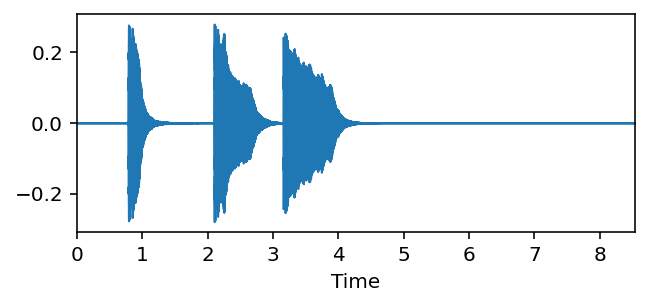

In [110]:
#forma de onda
plt.figure(figsize=(5,2))
librosa.display.waveplot(x,samplerate)

# **Transformada:**

Descompone el audio en las diferentes frecuencias suenan en el tiempo

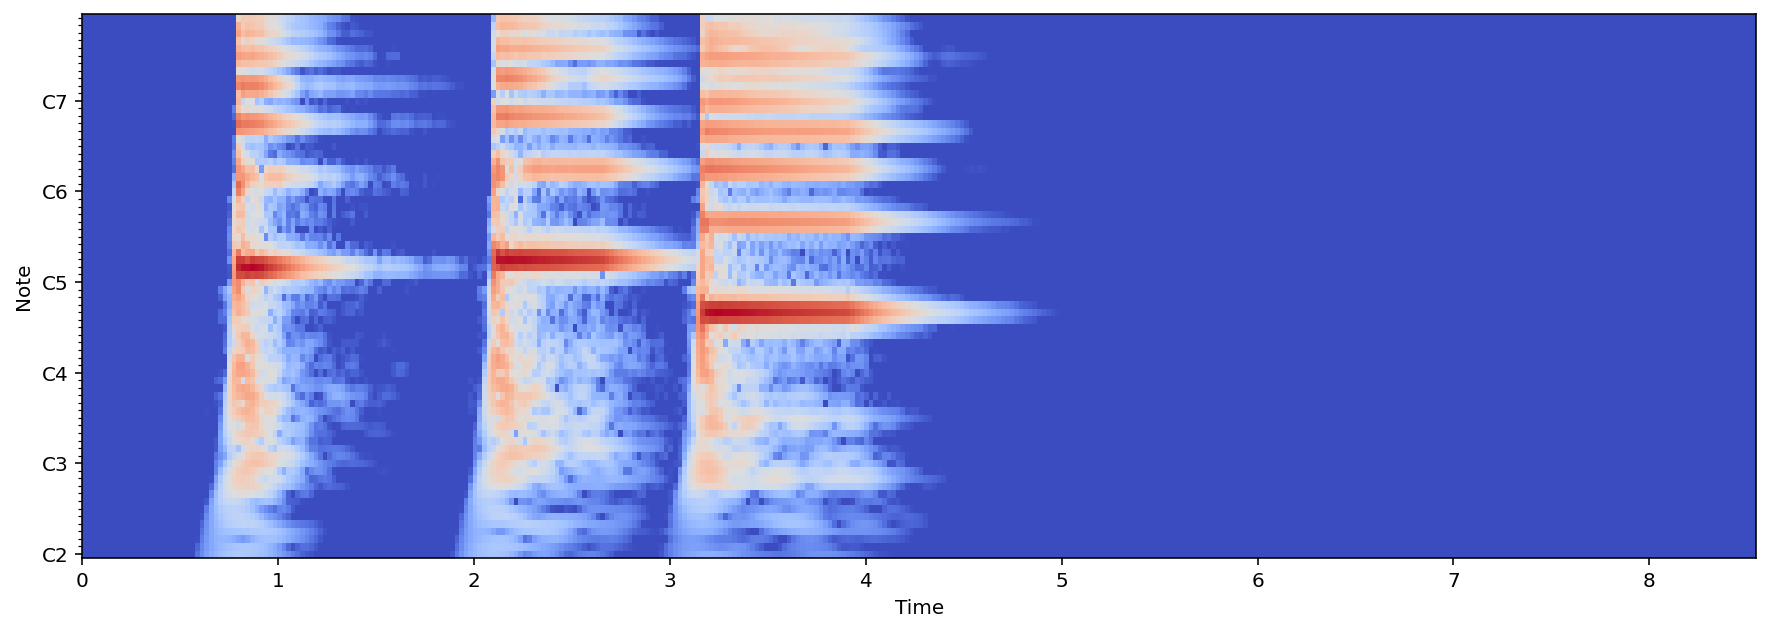

In [111]:
#funcion para calcular la transformada

fmin = librosa.midi_to_hz(36)

cqt = librosa.cqt(x, sr=samplerate, hop_length=hop_length, fmin=None, n_bins=bins, bins_per_octave=12, tuning=0.0)
logCqt = librosa.amplitude_to_db(np.abs(cqt))

plt.figure(figsize=(15,5))
librosa.display.specshow(logCqt, sr=samplerate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

In [112]:
#funcion para eliminar los ruidos de fondo o notas no deseadas
def cqt_umbral(cqt,thres=umbral_cqt):
    cqt_final=np.copy(cqt)
    cqt_final[cqt<thres]=-120
    return cqt_final

cqt_umbral(cqt,thres=umbral_cqt)

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

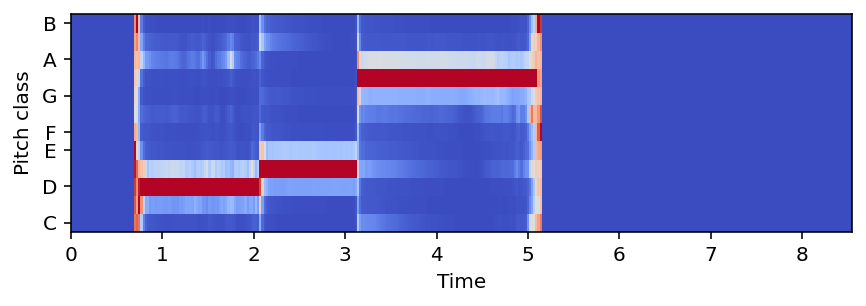

In [113]:
cromagrama = librosa.feature.chroma_stft(x, sr=samplerate, hop_length=hop_length)
plt.figure(figsize=(7, 2))
librosa.display.specshow(cromagrama, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# **Onset detection:**

detectar eventos musicales, es decir, cuando empieza y cuando termina cada nota

(0.0, 368.0)

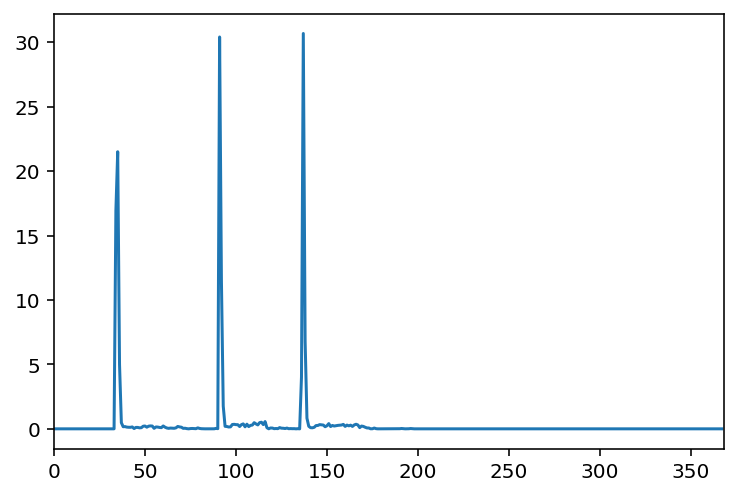

In [114]:
#importante 
#def calc_onset_envelope(x, cqt):
onset_envelope = librosa.onset.onset_strength(x, sr=samplerate, aggregate=np.mean, hop_length=hop_length)
plt.plot(onset_envelope)
plt.xlim(0, len(onset_envelope))
#return onset_envelope

#calc_onset_envelope(x,cqt)

[7.66258503e-01 2.08979592e+00 3.13469388e+00 4.37352490e+03]


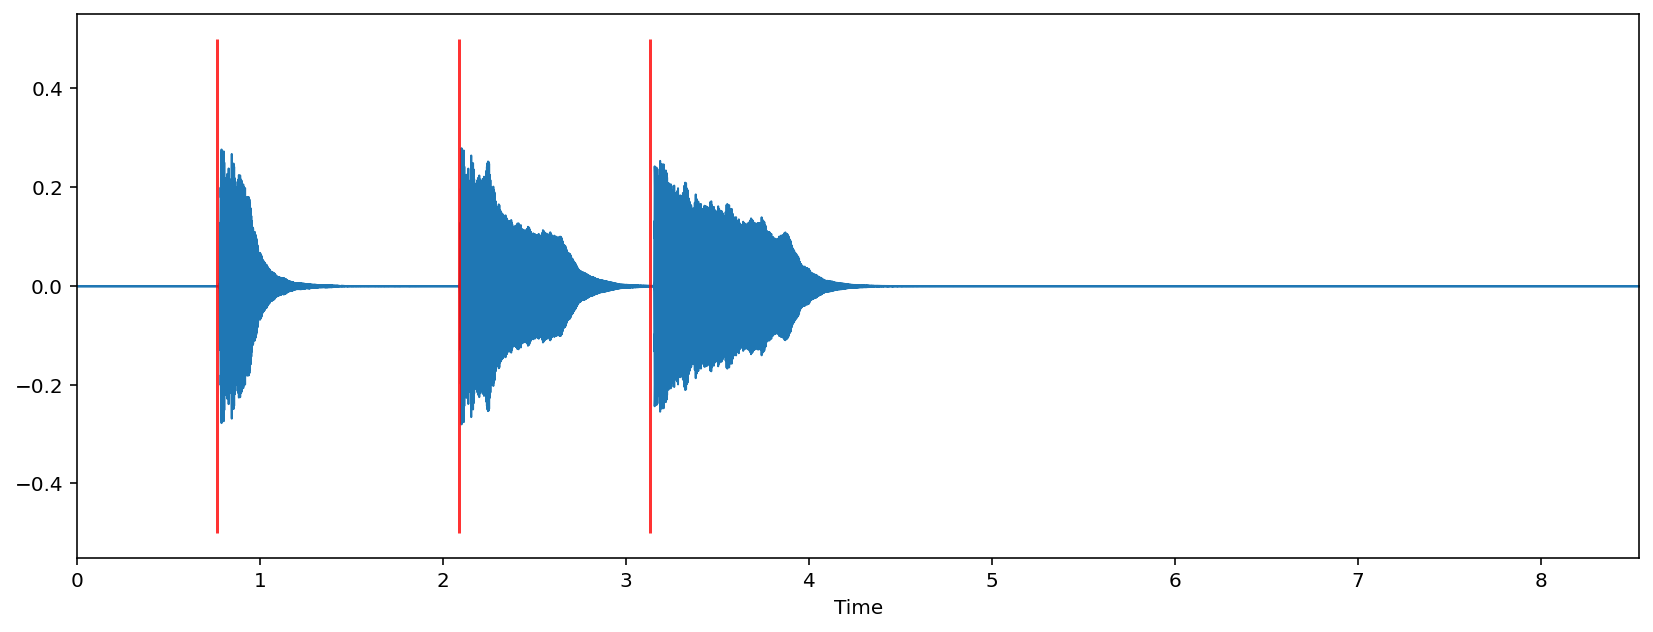

In [129]:
#estima adonde hay un onset
onsets = librosa.onset.onset_detect(onset_envelope=onset_envelope,
                                          sr=samplerate, units = 'frames',
                                          hop_length=512, 
                                          backtrack=True,
                                          pre_max=6,
                                          post_max=6)


onset_limites = np.concatenate([onsets, [len(x)]])


#convierte la estimacion de los onsets a segundos
onset_segs = (librosa.frames_to_time(onset_limites)) 
print (onset_segs)


#grafico de los onsets sobre la forma de onda
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=samplerate)
plt.vlines(onset_segs, -0.5, 0.5, color='r', alpha=0.8) 

# **Mas aspectos musicales**
duracion de las notas, generador de sinusoides, tempo etc...


In [116]:
#esta funcion es una que encontramos la cual estima frecuencias usando el metodo de correlacion
def estimar_frecuencias(segment, samplerate, frec_min=50.0, frec_max=20000.0):
    
    # Compute autocorrelation of input segment.
    correlacion = librosa.autocorrelate(segment)
    
    lim_min = samplerate/frec_max
    lim_max = samplerate/frec_min
    correlacion[:int(lim_min)] = 0
    correlacion[int(lim_max):] = 0
    
    # Find the location of the maximum autocorrelation
    i = correlacion.argmax()
    frecuencias = float(samplerate)/i
    return frecuencias

# **Duracion de las notas**

In [117]:
#sacar duracion de las notas
#def duracion(onset_segs):
PairNum = len(onset_segs) / 2
LoopsCompleted = 0
EvaluatedIndex = 1
Duration = []
while LoopsCompleted < PairNum:
  
  Duration.append(onset_segs[EvaluatedIndex] - onset_segs[EvaluatedIndex - 1])
  EvaluatedIndex += 2
  LoopsCompleted += 1

  #umbral para eliminar sonidos con poca duracion

  #umbral_duracion = onset_segs.filter(umbral_duracion, onset_segs)
  #print(umbral_duracion)

  #return Duration

#duracion(onset_segs)


## Traduccion a ondas senoidales:


In [118]:
def generar_sinusoide(frecuencias, sr, Duration):
    n = np.arange(Duration)
    return 0.2*np.sin(2*np.pi*frecuencias*n/float(sr)) 

In [119]:
def generar_sinusoides_por_estimacion(x, onsets, i, samplerate):
    n0 = onset_limites[i]
    n1 = onset_limites[i+1]
    frecuencias = estimar_frecuencias(x[n0:n1], samplerate)
    return generar_sinusoide(frecuencias, samplerate, n1-n0)

In [120]:
y = np.concatenate([
    generar_sinusoides_por_estimacion(x, onsets, i, samplerate)
    for i in range(len(onset_limites)-1)
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sin
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
#audio de las notas en ondas senoidales
ipd.Audio(y, rate=samplerate)

## tempo y beat tracking:

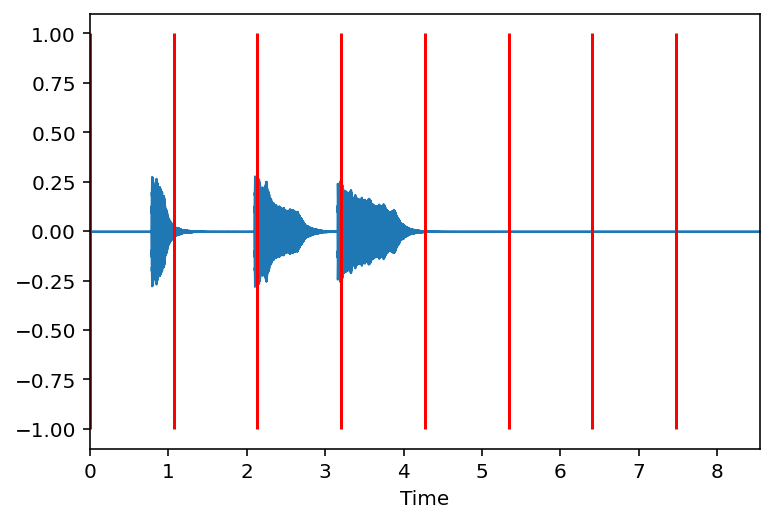

In [122]:
def sacarTempo(x,sr = samplerate):
  #saca tempo
  tempo = librosa.beat.tempo(x, sr=samplerate)

  #grafica tempo sobre la forma de onda
  T = len(x)/float(sr)
  segsXbeat = 60.0/tempo[0]
  beats = np.arange(0, T, segsXbeat)
  librosa.display.waveplot(x)
  plt.vlines(beats, -1, 1, color='r')

sacarTempo(x,samplerate)

# **Traduccion**

In [123]:
#aca empieza la traduccion a MIDI

#usando music21 podemos crear notas y luego pasarlas a pentagrama o a MIDI